## Some title and description
Using copernicusmarine toolbox for advecting particles!

<div class="alert alert-block alert-info">
<b>Note: </b> To run this example you will need to have the `copernicusmarine` toolbox isntalled.

</div>

In [1]:
# Library imports
from datetime import datetime, timedelta
import xarray as xr
import numpy as np

# parcels and plasticparcels imports
import os
os.chdir('../../')
print(os.getcwd())
import plasticparcels as pp
os.chdir('docs/examples/')

# Plotting imports
import matplotlib.pyplot as plt
from matplotlib.colors import LogNorm
import matplotlib.gridspec as gridspec
import matplotlib.ticker as mticker
import cartopy.crs as ccrs
import cartopy.feature as cfeature

/Users/denes001/Research/Projects/PlasticParcels/PlasticParcels


In [ ]:
# Make a copernicus settings dictionary
settings_file = 'docs/examples/copernicus_marine.json'
settings = pp.utils.load_settings(settings_file)

In [3]:
# Download the mask and release data
# TODO: determine a way of constructing the release maps for copernicusmarine datasets
settings = pp.utils.download_plasticparcels_dataset('NEMO0083', settings, 'input_data')


/Users/denes001/Research/Projects/PlasticParcels/PlasticParcels/plasticparcels/utils.py:168: UserWarning: Could not set settings path ('unbeaching', 'filename') for dataset 'NEMO0083'.
  warnings.warn(f"Could not set settings path {settings_path} for dataset {dataset!r}.", stacklevel=1)


In [4]:
# Create the simulation settings
settings['simulation'] = {
    'startdate': datetime.strptime('2024-01-01-00:00:00', '%Y-%m-%d-%H:%M:%S'), # Start date of simulation
    'runtime': timedelta(days=60),        # Runtime of simulation
    'outputdt': timedelta(hours=12),      # Timestep of output
    'dt': timedelta(minutes=20),          # Timestep of advection
    # Specific to copernicusmarine datasets, provide a bounding box and depth range for your simulation
    'boundingbox': [-5.0, 40.0, 30.0, 45.0],  # Bounding box of simulation [lonmin, lonmax, latmin, latmax]}
    'depth_range': [0, 500],               # Depth range of simulation [depthmin, depthmax] in meters
}

In [5]:
# Create the particle release settings
settings['release'] = {
    'initialisation_type': 'fisheries',
    'country': 'Italy',
}

In [6]:
# Create the plastic type settings
settings['plastictype'] = {
    'wind_coefficient' : 0.0,  # Percentage of wind to apply to particles
    'plastic_diameter' : 0.001, # Plastic particle diameter (m)
    'plastic_density' : 1028.,  # Plastic particle density (kg/m^3)
}

## Create a `FieldSet`, `ParticleSet` and `Kernel` list
Here we create the necessary `Parcels` objects to run our simulation. The `FieldSet` contains all the hydrodynamic, wind, and wave data required for our simulation. The `ParticleSet` is a set of particles initialised along the Italian coastline, and the `Kernel` list is a list of kernels that will be applied to these particles. A useful overview of these `Parcels` objects can be found [here](https://docs.parcels-code.org/en/latest/examples/tutorial_parcels_structure.html).

In [7]:
# Create the fieldset
fieldset = pp.constructors.create_fieldset(settings)

# Create the particleset
pset = pp.constructors.create_particleset_from_map(fieldset, settings)

# Create the applicable kernels to the plastic particles
kernels = pp.constructors.create_kernel(fieldset)

INFO - 2025-11-21T15:59:31Z - Selected dataset version: "202406"
INFO - 2025-11-21T15:59:31Z - Selected dataset part: "default"
WARNING - 2025-11-21T15:59:32Z - Some of your subset selection [0, 500] for the depth dimension exceed the dataset coordinates [0.49402499198913574, 5727.9169921875]
INFO - 2025-11-21T15:59:33Z - Selected dataset version: "202406"
INFO - 2025-11-21T15:59:33Z - Selected dataset part: "default"
WARNING - 2025-11-21T15:59:35Z - Some of your subset selection [0, 500] for the depth dimension exceed the dataset coordinates [0.49402499198913574, 5727.9169921875]
INFO - 2025-11-21T15:59:36Z - Selected dataset version: "202406"
INFO - 2025-11-21T15:59:36Z - Selected dataset part: "default"
WARNING - 2025-11-21T15:59:37Z - Some of your subset selection [0, 500] for the depth dimension exceed the dataset coordinates [0.49402499198913574, 5727.9169921875]
INFO - 2025-11-21T15:59:38Z - Selected dataset version: "202406"
INFO - 2025-11-21T15:59:38Z - Selected dataset part: 

Define the runtime, the timestepping, and the output frequency of the simulation from the settings.

In [8]:
runtime = settings['simulation']['runtime']
dt = settings['simulation']['dt']
outputdt = settings['simulation']['outputdt']

In [9]:
# Create the particle file where output will be stored
pfile = pp.ParticleFile('example_copernicusmarine.zarr', pset, settings=settings, outputdt=outputdt)

# TODO: coastal might not match this model coast, it isn't the c-grid, so CHECK!

In [10]:
# Execute the simulation
pset.execute(kernels, runtime=runtime, dt=dt, output_file=pfile)

INFO: Output files are stored in example_copernicusmarine.zarr.
100%|██████████| 5184000.0/5184000.0 [20:45<00:00, 4161.58it/s] 


## Plot the trajectories
Finally, we produce a simple 'spaghetti' plot and and a concentration map of the trajectories to visualise their pathways. To understand how to work with `PlasticParcels` output, please see the `Parcels` tutorial [here](https://docs.parcels-code.org/en/latest/examples/tutorial_output.html).

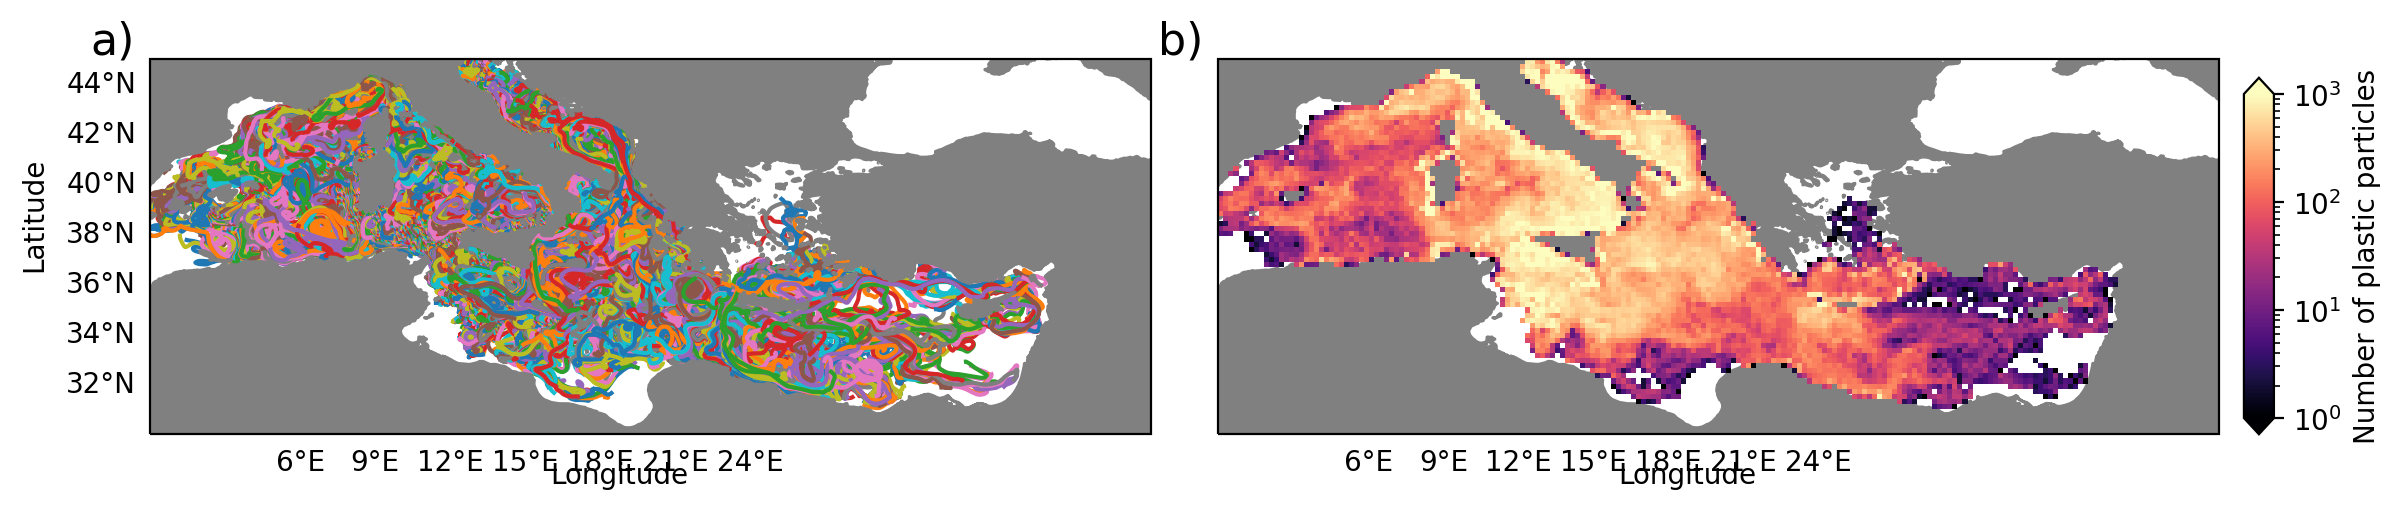

In [11]:
# Load the ParticleFile
ds = xr.open_zarr('example_copernicusmarine.zarr')

# Settings for the concentration map
bins = (np.linspace(0,40,200),np.linspace(30,45,75))
i = -1 # Use final timestep

# Create the figure object
plt.figure(figsize=(14,5), dpi=200)
gs = gridspec.GridSpec(1, 3, width_ratios=[30,30,1], wspace=0.1)
cb_axes_position = [1.025, 0.0, 0.03, 0.95]

# Plot the trajectories
ax = plt.subplot(gs[0,0], projection=ccrs.PlateCarree())
ax.plot(ds['lon'].T, ds['lat'].T, transform=ccrs.PlateCarree(), zorder=0)
ax.add_feature(cfeature.LAND, zorder=0, color='grey')

ax.set_extent([0,40,30,45], crs=ccrs.PlateCarree())
gl = ax.gridlines(draw_labels=True, dms=True, x_inline=False, y_inline=False,color = "None")
gl.top_labels = False
gl.right_labels = False
gl.xlocator = mticker.FixedLocator([6,9,12,15,18,21,24])

ax.text(-0.06, 1.015, 'a)', transform=ax.transAxes, size=16)
ax.text(-0.13, 0.45, 'Latitude', transform=ax.transAxes, size=10, rotation=90)
ax.text(0.4, -0.13, 'Longitude', transform=ax.transAxes, size=10)

# Plot the Concentration map
ax = plt.subplot(gs[0,1], projection=ccrs.PlateCarree())
cb = ax.hist2d(ds['lon'][:,:i].values.flatten(),ds['lat'][:,:i].values.flatten(), bins=bins,norm=LogNorm(vmin=1, vmax=1000), cmap=plt.cm.magma, transform=ccrs.PlateCarree())
ax.add_feature(cfeature.LAND, zorder=0, color='grey')

cbar_ax = ax.inset_axes(cb_axes_position)
cbar = plt.colorbar(cb[3], cax=cbar_ax, extend='both')
cbar.set_label('Number of plastic particles', fontsize=10)
gl = ax.gridlines(draw_labels=True, dms=True, x_inline=False, y_inline=False,color = "None")
gl.top_labels = False
gl.right_labels = False
gl.left_labels = False
gl.xlocator = mticker.FixedLocator([6,9,12,15,18,21,24])

ax.text(-0.06, 1.015, 'b)', transform=ax.transAxes, size=16)
ax.text(0.4, -0.13, 'Longitude', transform=ax.transAxes, size=10)

plt.show()